In [1]:
!pip install -r requirements.txt

  Using cached chromadb-1.2.1-cp39-abi3-win_amd64.whl.metadata (7.4 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.38.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached opentelemetry_sdk-1.38.0-py3-none-any.whl.metadata (1.5 kB)
Using cached chromadb-1.2.1-cp39-abi3-win_amd64.whl (20.7 MB)
Using cached opentelemetry_exporter_otlp_proto_grpc-1.38.0-py3-none-any.whl (19 kB)
Using cached opentelemetry_sdk-1.38.0-py3-none-any.whl (132 kB)

   ---------------------------------------- 0/3 [opentelemetry-sdk]
   ---------------------------------------- 0/3 [opentelemetry-sdk]
   ---------------------------------------- 0/3 [opentelemetry-sdk]
   ---------------------------------------- 0/3 [opentelemetry-sdk]
   ---------------------------------------- 0/3 [opentelemetry-sdk]
   ---------------------------------------- 0/3 [opentelemetry-sdk]
   -------------------------- ------------- 2/3 [chromadb]
   -------------------------- ------------- 2/3 [chromadb]
   -----------------

# INIT and Test Gemini

In [2]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv

# Load API key from .env file (create .env with GOOGLE_API_KEY=your_key)
load_dotenv()
google_api_key = os.getenv("GOOGLE_API_KEY")

# Initialize free Gemini model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    google_api_key=google_api_key,
    max_output_tokens=5000
)

# Define a prompt template
prompt = ChatPromptTemplate.from_template("Write a one-sentence fun fact about {topic}.")

# Create a chain: Prompt | LLM
chain = prompt | llm

# Invoke the chain
input_data = {"topic": "Large Language Models"}
response = chain.invoke(input_data)

print("Chain Test Successful.")
print(f"\nPrompt Input: {input_data['topic']}")
print(f"\nResponse Content:\n{response.content.strip()}")


Chain Test Successful.

Prompt Input: Large Language Models

Response Content:
Despite just predicting the next word, Large Language Models can write Shakespearean sonnets, debug code, and even invent recipes, making them the ultimate digital improv artists.


# Part 1: Document Extraction & Prompt Engineering with LangChain 

In [3]:
from langchain_community.document_loaders import PyMuPDFLoader

# Load the document uding PyMuPDFLoader
loader = PyMuPDFLoader("fy2024_analysis_of_revenue_and_expenditure.pdf")
docs = loader.load()

# Print the document length
print(f"Total number of pages: {len(docs)}")

# Print contents page by page
for i, doc in enumerate(docs, 1):
    print(f"PAGE {i}")
    print("=" * 30)
    print(doc.page_content)
    print("\n" + "-" * 50 + "\n")


Total number of pages: 37
PAGE 1
ANALYSIS OF  
REVENUE AND 
EXPENDITURE 
Financial Year 2024  
 
 
 
 
 
 
 
 
 
Distributed on Budget Day: 16 February 2024

--------------------------------------------------

PAGE 2
MINISTRY OF FINANCE 
 
2 
 
 
 
 
 
 
 
 
EXPLANATORY NOTES 
 
This document summarises and provides relevant 
highlights of the FY2024 Revenue and Expenditure 
Estimates presented to Parliament on 16 February 2024.

--------------------------------------------------

PAGE 3
MINISTRY OF FINANCE 
 
3 
 
CONTENTS 
 
ANALYSIS OF REVENUE AND EXPENDITURE ............... 4 
01 
Update on Financial Year 2023 ........................................................................ 5 
1.1 
Expected Overall Fiscal Position for FY2023 
5 
1.2 
Operating Revenue 
5 
1.3 
Total Expenditure 
6 
1.4 
Special Transfers 
7 
1.5 
Net Investment Returns Contribution 
7 
1.6 
Spending from Endowment Funds and Trust Funds 
7 
1.7 
Capitalisation of Nationally Significant Infrastructure and SIN

In [4]:
from langchain_community.document_loaders import PDFPlumberLoader

# Load the document using PDFPlumberLoader
loader = PDFPlumberLoader("fy2024_analysis_of_revenue_and_expenditure.pdf")
docs = loader.load()

# Print the document length
print(f"Total number of pages: {len(docs)}")

# Print contents page by page
for i, doc in enumerate(docs, 1):
    print(f"PAGE {i}")
    print("=" * 30)
    print(doc.page_content)
    print("\n" + "-" * 50 + "\n")

Cannot set gray non-stroke color because /'P115' is an invalid float value
Cannot set gray non-stroke color because /'P117' is an invalid float value


Total number of pages: 37
PAGE 1
ANALYSIS OF
REVENUE AND
EXPENDITURE
Financial Year 2024
Distributed on Budget Day: 16 February 2024


--------------------------------------------------

PAGE 2
EXPLANATORY NOTES
This document summarises and provides relevant
highlights of the FY2024 Revenue and Expenditure
Estimates presented to Parliament on 16 February 2024.
MINISTRY OF FINANCE 2


--------------------------------------------------

PAGE 3
CONTENTS
ANALYSIS OF REVENUE AND EXPENDITURE ............... 4
01 Update on Financial Year 2023 ........................................................................ 5
1.1 Expected Overall Fiscal Position for FY2023 5
1.2 Operating Revenue 5
1.3 Total Expenditure 6
1.4 Special Transfers 7
1.5 Net Investment Returns Contribution 7
1.6 Spending from Endowment Funds and Trust Funds 7
1.7 Capitalisation of Nationally Significant Infrastructure and SINGA
Interest Costs and Loan Expenses 7
02 Outlook for Financial Year 2024 ...........................

In [5]:
# we require only the following pages for part 2: 5, 6, 8, 20 from the docs
# take only the page content from the docs
# since the amount of data is not large, we can just pass it directly to the model without the need for embedding or creating a vector store
DOC_CONTEXT = ""

target_pages = [5, 6, 8, 20]

for i in target_pages:
    # index starts at 0
    doc = docs[i - 1]

    # Structure Page in String
    formatted_page_block = (
        f"PAGE {i}\n"
        f"{'=' * 30}\n"
        f"{doc.page_content}\n"
        f"\n{'-' * 50}\n\n" # Added an extra newline at the end to separate blocks
    )

    DOC_CONTEXT += formatted_page_block

print(f"Document context:\n\n{DOC_CONTEXT}")


Document context:

PAGE 5
01 Update on Financial Year 2023
1.1 Expected Overall Fiscal Position for FY2023
The basic deficit is revised to $5.4 billion (0.8% of GDP). After factoring in Top-
ups to Endowment and Trust Funds of $24.3 billion, Net Investment Returns
Contribution (NIRC) of $22.9 billion, Capitalisation of Nationally Significant
Infrastructure of $3.5 billion, and Significant Infrastructure Government Loan
Act (SINGA) Interest Costs and Loan Expenses of $0.2 billion, the Overall Fiscal
Position for Revised FY2023 is a deficit of $3.6 billion (0.5% of GDP). This is larger
than the $0.4 billion deficit estimated at Budget 2023. This is due to higher Total
Expenditure to meet priority areas such as catching up of projects deferred due
to COVID-19; funding for public healthcare institutions; and a top-up to the
Majulah Package Fund to boost the retirement and healthcare adequacy of
Singaporeans, as announced by Prime Minister Lee Hsien Loong at the National
Day Rally 2023; par

In [6]:
from pydantic import BaseModel, Field
from typing import List
import json

# Define the structured fields required to be extracted from the document
class extraction(BaseModel):
    corporate_income_tax: float = Field(description="Value of Corporate Income Tax in 2024 on page 5")
    corporate_yoy_income_tax: float = Field(description="The 'Compared to Estimated FY2023' percentage change for Corporate Income Tax from Table 1.1. Must be the percentage value on page 5")
    total_top_ups : float = Field(description="Total amount of top ups in 2024 in billions")
    operating_revenue_taxes: List[str] = Field(description="A list of the specific tax types mentioned in 'Operating Revenue' Section")
    latest_actual_fiscal_position: float = Field(description="Latest Actual Fiscal Position in billions")

SCHEMA = extraction.model_json_schema()
print(f"Schema of the fields to extract: {json.dumps(SCHEMA, indent=2)}")

Schema of the fields to extract: {
  "properties": {
    "corporate_income_tax": {
      "description": "Value of Corporate Income Tax in 2024 on page 5",
      "title": "Corporate Income Tax",
      "type": "number"
    },
    "corporate_yoy_income_tax": {
      "description": "The 'Compared to Estimated FY2023' percentage change for Corporate Income Tax from Table 1.1. Must be the percentage value on page 5",
      "title": "Corporate Yoy Income Tax",
      "type": "number"
    },
    "total_top_ups": {
      "description": "Total amount of top ups in 2024 in billions",
      "title": "Total Top Ups",
      "type": "number"
    },
    "operating_revenue_taxes": {
      "description": "A list of the specific tax types mentioned in 'Operating Revenue' Section",
      "items": {
        "type": "string"
      },
      "title": "Operating Revenue Taxes",
      "type": "array"
    },
    "latest_actual_fiscal_position": {
      "description": "Latest Actual Fiscal Position in billions",
 

In [7]:
from langchain_core.prompts import ChatPromptTemplate

SYSTEM_PROMPT = """
Your sole task is to extract information from the provided DOCUMENT CONTEXT,  which is from the 
analysis of Revenue and Expenditure Financial Year 2024 based on the keys in the given JSON SCHEMA.

CRITICAL INSTRUCTIONS:
1. Output Format: Return the extracted data as a single, valid JSON object.
2. Schema Compliance: Use ONLY the field names from the schema as keys.
3. No Exceptions: DO NOT include any introductory text, explanations, markdown formatting (like ```json), or extra fields.
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", "{system}"),
    ("human", "JSON SCHEMA:\n{schema}\n\nDOCUMENT CONTEXT:\n{context}")
])

formatted_prompt = prompt.format_prompt(
    system = SYSTEM_PROMPT,
    schema = SCHEMA,
    context = DOC_CONTEXT
)

response = llm.invoke(formatted_prompt)

print(f"\nResponse Content (Expected JSON):\n{response.content.strip()}")


Response Content (Expected JSON):
```json
{"corporate_income_tax": 28.4, "corporate_yoy_income_tax": 17.0, "total_top_ups": 20.352, "operating_revenue_taxes": ["Corporate Income Tax", "Other Taxes", "Vehicle Quota Premiums", "Personal Income Tax", "Assets Taxes", "Betting Taxes", "Goods and Services Tax"], "latest_actual_fiscal_position": -3.57}
```


In [8]:
import json
import re

json_text = response.content.strip()
if "```json" in json_text:
    json_text = re.search(r'```json\s*(.*?)\s*```', json_text, re.DOTALL).group(1)
elif "```" in json_text:
    json_text = re.search(r'```\s*(.*?)\s*```', json_text, re.DOTALL).group(1)

data = json.loads(json_text)

print(f"""
Amount of Corporate Income Tax in 2024: ${data['corporate_income_tax']} billion
YOY percentage difference of Corp Income Tax in 2024: {data['corporate_yoy_income_tax']}%
Total amount of top ups in 2024: ${data['total_top_ups']} billion
List of taxes mentioned in sections: 
{chr(10).join(data['operating_revenue_taxes'])}
Latest Actual Fiscal Position in billions: ${data['latest_actual_fiscal_position']} billion
""")


Amount of Corporate Income Tax in 2024: $28.4 billion
YOY percentage difference of Corp Income Tax in 2024: 17.0%
Total amount of top ups in 2024: $20.352 billion
List of taxes mentioned in sections: 
Corporate Income Tax
Other Taxes
Vehicle Quota Premiums
Personal Income Tax
Assets Taxes
Betting Taxes
Goods and Services Tax
Latest Actual Fiscal Position in billions: $-3.57 billion



# Part 2: Tool Calling & Reasoning Integration

In [51]:
required_pages = filtered_docs = [docs[i-1].page_content for i in [1, 36]]

DOC_CONTEXT = "\n\n".join(required_pages)

print(f"Document context:\n\n {DOC_CONTEXT}")

Document context:

 ANALYSIS OF  
REVENUE AND 
EXPENDITURE 
Financial Year 2024  
 
 
 
 
 
 
 
 
 
Distributed on Budget Day: 16 February 2024

MINISTRY OF FINANCE 
 
36 
 
Glossary of Terms 
 
Assets Taxes  
Assets Taxes refer to Property Tax and Estate 
Duty. Property Tax is a tax on the ownership of 
property and is payable by all property owners 
on the properties owned by them. Estate Duty 
is a tax on the total market value of a person's 
assets (cash and non-cash) at the date of his or 
her death. Estate Duty does not apply to a 
person who dies after 15 February 2008.  
 
Customs Duties 
Taxes on goods imported into Singapore. In 
Singapore, Customs Duties are principally 
imposed on alcoholic beverages. 
 
Development Expenditure 
Expenses 
that 
represent 
a 
longer-term 
investment and/or are incurred on capital assets 
in respect of or in connection with the economic 
development or general welfare of Singapore. 
Examples of spending areas are on the 
acquisition of heavy 

In [52]:
from pydantic import BaseModel, Field
from typing import List
import json

# Define the structured fields required to be extracted from the document
class extraction(BaseModel):
    distribution_date: str = Field(description="The full raw text of the document's distribution date in ISO format")
    estate_duty: str = Field(description="The full raw text of the date relating to estate duty return in ISO format")
SCHEMA = extraction.model_json_schema()
print(f"Schema of the fields to extract: {json.dumps(SCHEMA, indent=2)}")

Schema of the fields to extract: {
  "properties": {
    "distribution_date": {
      "description": "The full raw text of the document's distribution date in ISO format",
      "title": "Distribution Date",
      "type": "string"
    },
    "estate_duty": {
      "description": "The full raw text of the date relating to estate duty return in ISO format",
      "title": "Estate Duty",
      "type": "string"
    }
  },
  "required": [
    "distribution_date",
    "estate_duty"
  ],
  "title": "extraction",
  "type": "object"
}


In [53]:
from dateutil.parser import parse
from dateutil.parser import ParserError
from langchain.tools import tool

class DateToIsoInput(BaseModel):
    date_str: str = Field(description="The date string to convert (e.g., '16 February 2024').")

@tool (args_schema=DateToIsoInput)
def date_to_iso(date_str: str) -> str:
    """Convert a date string to an ISO 8601 date string."""
    try:
        # try to parse the date string
        date_obj = parse(date_str, fuzzy=True)
        return date_obj.date().isoformat()
    except ParserError:
        print(f"Warning: Could not parse date string: '{date_str}'. Returning original string.")
        return date_str
    
# Test the tool
print(date_to_iso.invoke("16 February 2024"))

2024-02-16


In [54]:
from langchain.agents import create_agent
from langchain.tools import tool, ToolRuntime

SYSTEM_PROMPT = """
Your sole task is to extract information from the provided DOCUMENT CONTEXT,  which is from the 
analysis of Revenue and Expenditure Financial Year 2024 based on the keys in the given JSON SCHEMA.

CRITICAL INSTRUCTIONS:
1. Output Format: Return the extracted data as a single, valid JSON object.
2. Schema Compliance: Use ONLY the field names from the schema as keys.
3. No Exceptions: DO NOT include any introductory text, explanations, markdown formatting (like ```json), or extra fields.
4. All Dates extracted need to be normalised using tools such as date_to_iso.
"""

# The prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "{prompt}"),
        ("human", "DOCUMENT_CONTEXT: {content}\n\nJSON_SCHEMA: {schema}\n\n"),
    ]
)

tools = [
    date_to_iso
]

# Format the prompt with your context and schema
input_messages = prompt.format_messages(
    prompt=SYSTEM_PROMPT,
    content= DOC_CONTEXT,
    schema= SCHEMA
)

model = llm.bind_tools(tools) # Bind the tools to the model

# This connects the LLM, the tools, and the prompt to create the core decision-making unit.
# Test the model with tools
res = model.invoke(input_messages)

print(res)


content='' additional_kwargs={'function_call': {'name': 'date_to_iso', 'arguments': '{"date_str": "16 February 2024"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--6ce23250-1ab4-466d-b669-017501b5e7e0-0' tool_calls=[{'name': 'date_to_iso', 'args': {'date_str': '16 February 2024'}, 'id': 'c26704e3-f24f-4cdc-b4c1-fa32ae74ccab', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1136, 'output_tokens': 139, 'total_tokens': 1275, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 113}}


### Graph Creation Section
This is taken from the gemini api documentation https://ai.google.dev/gemini-api/docs/langgraph-example

In [55]:
from typing import Annotated,Sequence, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from langgraph.graph.message import add_messages # helper function to add messages to the state


class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

In [56]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def call_tool(state: AgentState):
    outputs = []
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # Invoke the model with the system prompt and the messages
    messages = state["messages"]
    if not any(isinstance(m, SystemMessage) for m in messages):
        messages = input_messages
    response = model.invoke(state["messages"], config)
    # We return a list, because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
    # default to continue
    return "continue"

In [57]:
from langgraph.graph import StateGraph, END

# Define a new graph with our state
workflow = StateGraph(AgentState)

# 1. Add our nodes 
workflow.add_node("llm", call_model)
workflow.add_node("tools",  call_tool)
# 2. Set the entrypoint as `agent`, this is the first node called
workflow.set_entry_point("llm")
# 3. Add a conditional edge after the `llm` node is called.
workflow.add_conditional_edges(
    # Edge is used after the `llm` node is called.
    "llm",
    # The function that will determine which node is called next.
    should_continue,
    # Mapping for where to go next, keys are strings from the function return, and the values are other nodes.
    # END is a special node marking that the graph is finish.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)
# 4. Add a normal edge after `tools` is called, `llm` node is called next.
workflow.add_edge("tools", "llm")

# Now we can compile and visualize our graph
graph = workflow.compile()

In [58]:
from langgraph.graph import StateGraph, END

# Define a new graph with our state
workflow = StateGraph(AgentState)

# 1. Add our nodes 
workflow.add_node("llm", call_model)
workflow.add_node("tools",  call_tool)
# 2. Set the entrypoint as `agent`, this is the first node called
workflow.set_entry_point("llm")
# 3. Add a conditional edge after the `llm` node is called.
workflow.add_conditional_edges(
    # Edge is used after the `llm` node is called.
    "llm",
    # The function that will determine which node is called next.
    should_continue,
    # Mapping for where to go next, keys are strings from the function return, and the values are other nodes.
    # END is a special node marking that the graph is finish.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)
# 4. Add a normal edge after `tools` is called, `llm` node is called next.
workflow.add_edge("tools", "llm")

# Now we can compile and visualize our graph
graph = workflow.compile()

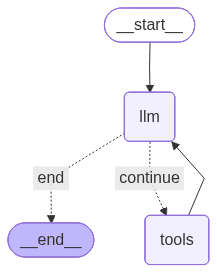

In [59]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Task 1 Data Extraction + Datetime Tool via local MCP

In [60]:
from datetime import datetime
from langchain_core.messages import AIMessage, ToolMessage
# Create our initial message dictionary
inputs = {"messages": input_messages}

# call our graph with streaming to see the steps
for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]

    if isinstance(last_message, (AIMessage, ToolMessage)):
        last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  date_to_iso (252c4bb3-2489-438a-9546-f6816561efad)
 Call ID: 252c4bb3-2489-438a-9546-f6816561efad
  Args:
    date_str: 16 February 2024
================================= Tool Message =================================
Name: date_to_iso

2024-02-16
================================== Ai Message ==================================
Tool Calls:
  date_to_iso (382376ba-361d-4b24-b40b-947c77234f04)
 Call ID: 382376ba-361d-4b24-b40b-947c77234f04
  Args:
    date_str: 15 February 2008
================================= Tool Message =================================
Name: date_to_iso

2008-02-15
================================== Ai Message ==================================

{"distribution_date": "2024-02-16", "estate_duty": "2008-02-15"}


### Task 2 Reasoning over Normalised Date

In [61]:

class DateToIsoOutpt(BaseModel):
    original_text: str = Field(
        description="The original date string as it appeared in the source document."
    )
    normalized_date: str = Field(
        description="The date string successfully converted to ISO 8601 format (YYYY-MM-DD)."
    )
    status: str = Field(
        description="The category of the date when compared against 2024-01-01."
    )
    
OUTPUT_FORMAT = DateToIsoOutpt.model_json_schema()

SYSTEM_PROMPT = """
Your sole task is to extract information from the provided DOCUMENT CONTEXT,  which is from the 
analysis of Revenue and Expenditure Financial Year 2024 based on the keys in the given JSON SCHEMA.

CRITICAL INSTRUCTIONS:
1. Output Format: Return the extracted data as a single, valid JSON object.
2. Schema Compliance: Use ONLY the field names from the schema as keys.
3. No Exceptions: DO NOT include any introductory text, explanations, markdown formatting (like ```json), or extra fields.
4. All Dates extracted need to be normalised using tools such as date_to_iso.
5. Evaluate all of the normalised dates against the date of 2024-01-01. Categorise the dates into one of these 3 states:
    - Expired: Before 2024-01-01
    - Upcoming: The date is after 2024-01-01
    - Ongoing: The date refers to a period that is currently active.

Each date should be formatted as a JSON object with the OUTPUT_FORMAT

"""

# The prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "{prompt}"),
        ("human", "DOCUMENT_CONTEXT: {content}\n\nJSON_SCHEMA: {schema}\n\nOUTPUT_FORMAT: {output_format}"),
    ]
)

tools = [
    date_to_iso
]

# Format the prompt with your context and schema
input_messages = prompt.format_messages(
    prompt=SYSTEM_PROMPT,
    content= DOC_CONTEXT,
    schema= SCHEMA,
    output_format= OUTPUT_FORMAT
)

In [105]:
inputs = {"messages": input_messages}

# call our graph with streaming to see the steps
for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]

    if isinstance(last_message, (AIMessage, ToolMessage)):
        last_message.pretty_print()


================================== Ai Message ==================================

[{'type': 'text', 'text': '```json\n{"distribution_date": {"original_text": "16 February 2024", "normalized_date": "2024-02-16", "status": "Upcoming"}, "estate_duty": {"original_text": "15 February 2008", "normalized_date": "2008-02-15", "status": "Expired"}}\n```', 'extras': {'signature': 'CqEGAdHtim8xL0OJj6x08u/vvhBkHu6/JpXGXbHhjpC2ezPCYmJWTipqcgfjtQZ/1pKoGlX7KxxXAt3i1BQPWD+YwgcTpjNim4MZBHiQ5b2P4KSXHNJGar0IPZRZ9X02QkGBmdtQQqEYXZZpeEU5QPY7yrrGhoHVvjw+C17qsRzAEmd2XIqh1sjNHht4JE+FtY3YpWRrbo0CNbVX0eZqz0GNBbG5SWDq9defkjYv3H27+W/m3zXBHJRnBLxdekdxXna/o1MiyZ6RV8w0TzTrygtrYOyR9T4h3RXj6M4f9u4C0cGgrjPmJH9mYf4BWk9MhuSWQfp9UoW4wYsMujnqiIEm0NXr5Hn6tsfCzAgsB++aon9siFf4+DFx2risk/VId6Y6B/CG/hhdr/n9K87bun4TavHl0Ig4ZC36mNJ+kxxaETNUomvX6s2dVp/LeColowJHvKq5cgfaCVSjzWY4cK8enwOk2m479Udv6kV7+5i0AlA75+g/Upz3O1pUysLvW1pnYkYrsbplPOyb+190zWPisLPn8wP92nbv5FP4Gk9ySvBH9Agkv0GTc+KXgYSluJLOz/cYI9FhA7oJ7jJCGXLjmWltcmiRSUgCOBg9POhLAHurP6

In [63]:
json_text = last_message.content[0]['text']

# Clense the json_text before loading
if "```json" in json_text:
    json_text = re.search(r'```json\s*(.*?)\s*```', json_text, re.DOTALL).group(1)
elif "```" in json_text:
    json_text = re.search(r'```\s*(.*?)\s*```', json_text, re.DOTALL).group(1)

# Load the Json
data = json.loads(json_text)

print(json.dumps(data, indent=4))

TypeError: string indices must be integers, not 'str'

# Part 3: Multi-Agent Supervisor

In [ ]:
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

# Load the document using PDFPlumberLoader
loader = PDFPlumberLoader("fy2024_analysis_of_revenue_and_expenditure.pdf")
docs = loader.load()

# Print the document length
print(f"Total number of pages: {len(docs)}")

# Print contents page by page
for i, doc in enumerate(docs, 1):
    print(f"PAGE {i}")
    print("=" * 30)
    print(doc.page_content)
    print("\n" + "-" * 50 + "\n")

Cannot set gray non-stroke color because /'P115' is an invalid float value
Cannot set gray non-stroke color because /'P117' is an invalid float value


Total number of pages: 37
PAGE 1
ANALYSIS OF
REVENUE AND
EXPENDITURE
Financial Year 2024
Distributed on Budget Day: 16 February 2024


--------------------------------------------------

PAGE 2
EXPLANATORY NOTES
This document summarises and provides relevant
highlights of the FY2024 Revenue and Expenditure
Estimates presented to Parliament on 16 February 2024.
MINISTRY OF FINANCE 2


--------------------------------------------------

PAGE 3
CONTENTS
ANALYSIS OF REVENUE AND EXPENDITURE ............... 4
01 Update on Financial Year 2023 ........................................................................ 5
1.1 Expected Overall Fiscal Position for FY2023 5
1.2 Operating Revenue 5
1.3 Total Expenditure 6
1.4 Special Transfers 7
1.5 Net Investment Returns Contribution 7
1.6 Spending from Endowment Funds and Trust Funds 7
1.7 Capitalisation of Nationally Significant Infrastructure and SINGA
Interest Costs and Loan Expenses 7
02 Outlook for Financial Year 2024 ...........................

## RAG Setup with LangChain & Gemini(NOT IN USE)

The initial idea was to setup a vector database with RAG for the Project. However the embedding model is currently not free and rate limited. Thus will not be able to use RAG as a tools for the two worker agents to use. This was intended to to showcase how we can save some money by not dumping all of the data in the context windows, which will cost more money over times. Additionall its will be faster, and more efficient. However will be resorting to dumping after this section. Keeping Section just to show thinking process.

In [ ]:
# Testing RAG Setup

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="text-embedding-001",
    google_api_key=google_api_key
)

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001", google_api_key=google_api_key)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
print(f"Total number of splits: {len(splits)}")


vector_store = Chroma.from_documents(
    documents=splits, 
    embedding=embeddings, 
    persist_directory="./chroma_langchain_db",
    collection_name="Financial-Document",
)

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

Total number of splits: 84


GoogleGenerativeAIError: Error embedding content: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit.
* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0 [violations {
  quota_metric: "generativelanguage.googleapis.com/embed_content_free_tier_requests"
  quota_id: "EmbedContentRequestsPerMinutePerUserPerProjectPerModel-FreeTier"
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
]

## Setup

In [126]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, MessagesState, END

load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")


# Load PDF document
loader = PyMuPDFLoader("fy2024_analysis_of_revenue_and_expenditure.pdf")
docs = loader.load()
full_text = "\n".join([doc.page_content for doc in docs])
print(f"Loaded {len(docs)} pages")

# Initialize LLMs
revenue_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
expenditure_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
supervisor_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

Loaded 37 pages


## Agents as Tools

In [127]:
# Define agent tools
@tool
def revenue_agent(query: str) -> str:
    """Specializes in identifying and extracting government revenue information."""
    system_prompt = """You are a revenue analysis expert. Extract actual data, figures, and specific revenue streams from the document. Do not provide meta-information."""
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"{query}\n\nDocument:\n{full_text}")
    ]
    return revenue_llm.invoke(messages).content

@tool
def expenditure_agent(query: str) -> str:
    """Specializes in finding and analyzing government spending and fund information."""
    system_prompt = """You are an expenditure analysis expert. Extract actual data, figures, and specific fund details from the document. Do not provide meta-information."""
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"{query}\n\nDocument:\n{full_text}")
    ]
    return expenditure_llm.invoke(messages).content

tools = [revenue_agent, expenditure_agent]
print(f"Tool names: {[t.name for t in tools]}")

Tool names: ['revenue_agent', 'expenditure_agent']


## LangGraph Nodes & Methods Setup

In [128]:
# Supervisor system prompt
SUPERVISOR_PROMPT = """You are a supervisor agent coordinating specialized agents to answer user queries.

Your role:
1. Analyze the user query to determine which specialized agents are needed
2. Delegate sub-tasks to the appropriate agents:
   - revenue_agent: For questions about government revenue streams
   - expenditure_agent: For questions about government spending and funds
3. Synthesize the responses from agents into a comprehensive answer

CRITICAL INSTRUCTIONS:
- Use the available tools to delegate tasks to specialized agents
- Formulate clear, specific queries for each agent
- After receiving responses, provide a coherent final answer
- format the final answer properly in text format
"""

# Bind tools to supervisor
supervisor_with_tools = supervisor_llm.bind_tools(tools)

# Call tool node
def call_tools(state: MessagesState):
    tool_calls_by_name = {t.name: t for t in tools}
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tool_calls_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

# Supervisor node
def supervisor(state: MessagesState):
    messages = state["messages"]
    if not any(isinstance(m, SystemMessage) for m in messages):
        messages = [SystemMessage(content=SUPERVISOR_PROMPT)] + messages
    response = supervisor_with_tools.invoke(messages)
    return {"messages": [response]}

# Router
def should_continue(state: MessagesState):
    if not state["messages"][-1].tool_calls:
        return "end"
    return "continue"

In [129]:
# Build workflow
workflow = StateGraph(MessagesState)

workflow.add_node("supervisor", supervisor)
workflow.add_node("tools", call_tools)

workflow.set_entry_point("supervisor")
workflow.add_conditional_edges("supervisor", should_continue, {"continue": "tools", "end": END})
workflow.add_edge("tools", "supervisor")

app = workflow.compile()

In [130]:
def query_agent(query: str) -> str:
    """Query the agent with the given query."""
    inputs = {"messages": [HumanMessage(content=query)]}
    for state in app.stream(inputs, stream_mode="values"):
        last_message = state["messages"][-1]
        if isinstance(last_message, (AIMessage, ToolMessage, SystemMessage)):
            last_message.pretty_print()

## Test Queries with Decision Making Trace

In [131]:

query_agent("What are the key government revenue streams, and how will the Budget for the Future Energy Fund be supported?")

================================== Ai Message ==================================
Tool Calls:
  revenue_agent (0b604d0e-f68c-4eea-8a52-b6277e1c0e9f)
 Call ID: 0b604d0e-f68c-4eea-8a52-b6277e1c0e9f
  Args:
    query: What are the key government revenue streams?
  expenditure_agent (97984640-7251-4698-b5c7-ccb1d097bdc1)
 Call ID: 97984640-7251-4698-b5c7-ccb1d097bdc1
  Args:
    query: How will the Budget for the Future Energy Fund be supported?
================================= Tool Message =================================
Name: expenditure_agent

The Future Energy Fund will be supported with an initial injection of $5.0 billion to invest in critical infrastructure for the energy transition.
================================== Ai Message ==================================

The key government revenue streams include:

*   **Corporate Income Tax**
*   **Personal Income Tax**
*   **Withholding Tax**
*   **Statutory Boards' Contributions**
*   **Assets Taxes**
*   **Customs, Excise and Carbon 

In [132]:
query_agent("""
What percentage of Total Operating Expenditure is covered by the combined revenue from Corporate Income Tax and Personal Income Tax in FY2024?
""")

================================== Ai Message ==================================
Tool Calls:
  revenue_agent (90eda2ff-1222-4a90-8f0f-464ea85aa0c1)
 Call ID: 90eda2ff-1222-4a90-8f0f-464ea85aa0c1
  Args:
    query: Corporate Income Tax and Personal Income Tax in FY2024
  expenditure_agent (881fcc18-c02f-49f6-91d5-2505e5357d53)
 Call ID: 881fcc18-c02f-49f6-91d5-2505e5357d53
  Args:
    query: Total Operating Expenditure in FY2024
================================= Tool Message =================================
Name: expenditure_agent

88.43 billion


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 42.210177484s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seco

================================== Ai Message ==================================

[{'type': 'text', 'text': 'In FY2024, the combined revenue from Corporate Income Tax ($28.03 billion) and Personal Income Tax ($18.07 billion) is $46.10 billion.\n\nTotal Operating Expenditure in FY2024 is $88.43 billion.\n\nTherefore, the combined revenue from Corporate Income Tax and Personal Income Tax covers approximately **52.13%** of the Total Operating Expenditure in FY2024.', 'extras': {'signature': 'CqUGAdHtim/t3GfdVR5mxLrZrxuFTpoiFSqQ4IyHFIkDq8VAPV7yctR0eB6+MYn1C3aHJ1UNuOC0Y5v521IKF9K2k5fKaTDRiBoTRhKO+7R/oJXdkQurX8uFdWIQV/akkijk1W1iwfchZs2YaF0coCLdcO7/fpexiB2vcLtD1IN6Lba09y8OoyblrMIF+PbW67v3rXI3FWEtydajoIVrPZ4m81dvUK8Bh4ryphIQ8m8KFqF+t04wzHgJ6kVLI34k2Q7IuERK5umv8zYWHQgJNQxWBTYk3sL+IaYZki9iF0UrwXNlXlBfqFop+X8qvjn1SsuKHaD3iS4dESGlzyIGcU6ipKGGlhChqpvTHQHmQdpxpf3zCuaDsohX4kx6lGlKzhmH+ywIRJrYjCO26Gu4/DOEwuW32+JThbzqJd0t5JNLucwPxZzgcWjnVTakY8nnHVAjQ6LdD8MJWA99083VbZN+bk6Zw6tdBSUXfzzt5Wy6lS2+B+xA9abxAS

In [133]:
query_agent("""
How much greater is the Net Investment Returns Contribution (NIRC) than the total estimated Development Expenditure for FY2024?
            """)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 37.007705236s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seco

================================== Ai Message ==================================
Tool Calls:
  revenue_agent (5ff0d1e2-f101-4c7d-bb22-b56ddf1c64f9)
 Call ID: 5ff0d1e2-f101-4c7d-bb22-b56ddf1c64f9
  Args:
    query: Net Investment Returns Contribution (NIRC)
  expenditure_agent (baf199ab-bc4a-4871-be74-7ae06b9ace86)
 Call ID: baf199ab-bc4a-4871-be74-7ae06b9ace86
  Args:
    query: total estimated Development Expenditure for FY2024
================================= Tool Message =================================
Name: expenditure_agent

23.33 billion
================================== Ai Message ==================================

[{'type': 'text', 'text': 'The Net Investment Returns Contribution (NIRC) for FY2024 is estimated to be $23,501 million ($23.501 billion). The total estimated Development Expenditure for FY2024 is $23.33 billion.\n\nTherefore, the NIRC is $0.171 billion greater than the total estimated Development Expenditure for FY2024.', 'extras': {'signature': 'CosHAdHtim9HuId

In [134]:
query_agent("""
Name the top three largest revenue streams, and how much of their combined total is committed to Top-ups to Endowment and Trust Funds in FY2024?
            """)

================================== Ai Message ==================================
Tool Calls:
  revenue_agent (738c3cd6-c40a-4b5c-8f56-de5533679e7b)
 Call ID: 738c3cd6-c40a-4b5c-8f56-de5533679e7b
  Args:
    query: top three largest revenue streams
================================= Tool Message =================================
Name: revenue_agent

1. Corporate Income Tax: $28.38 billion
2. Personal Income Tax: $17.53 billion
3. Goods and Services Tax: $16.36 billion
================================== Ai Message ==================================
Tool Calls:
  expenditure_agent (795878e0-04ef-4d62-9db7-29bfbddbb801)
 Call ID: 795878e0-04ef-4d62-9db7-29bfbddbb801
  Args:
    query: Top-ups to Endowment and Trust Funds in FY2024
================================= Tool Message =================================
Name: expenditure_agent

**Top-ups to Endowment and Trust Funds in FY2024:**

*   **Goods and Services Tax Voucher Fund:** $6,000 million
*   **Future Energy Fund:** $5,000 million
* 

In [135]:
query_agent("""
What is the total amount of revenue from Corporate Income Tax and Personal Income Tax in FY2024?
            """)

================================== Ai Message ==================================
Tool Calls:
  revenue_agent (b6990f04-50f2-45e4-8e1e-934c88681c1f)
 Call ID: b6990f04-50f2-45e4-8e1e-934c88681c1f
  Args:
    query: Total revenue from Corporate Income Tax and Personal Income Tax in FY2024
================================= Tool Message =================================
Name: revenue_agent

Corporate Income Tax: $28.03 billion
Personal Income Tax: $18.07 billion
================================== Ai Message ==================================

The total revenue from Corporate Income Tax in FY2024 is $28.03 billion, and from Personal Income Tax is $18.07 billion.
